In [ ]:
!pip install matplotlib

In [2]:
import torch
from diffusers import StableDiffusionPipeline
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

/home/admyyh/miniconda3/envs/vision_diffusion/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the Stable Diffusion pipeline and extract VAE
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4")
vae = pipe.vae.to(device)


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Fetching 16 files:   6%|▋         | 1/16 [00:00<00:04,  3.34it/s]Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install

In [ ]:
# Load and preprocess the image
image_path = "/home/admyyh/python_workspaces/vision_diffuser/data/celeba/subsets/celeba_256/3039.jpg"  # Replace with your image path
original_img = Image.open(image_path).convert("RGB")
original_img = original_img.resize((512, 512))  # Resize to 512x512
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Map to [-1,1]
])
x = preprocess(original_img).unsqueeze(0).to(device)  # Add batch dimension and move to device

In [ ]:
# Encode the image to get z
with torch.no_grad():
    z = vae.encode(x).latent_dist.mean

# Decode z to get the initial reconstruction
with torch.no_grad():
    recon1 = vae.decode(z).sample

In [ ]:
# Optimize z to better reconstruct the original image
z_optim = z.clone().detach().requires_grad_(True).to(device)
optimizer = torch.optim.Adam([z_optim], lr=0.01)
# Optimization loop
num_steps = 5000
for step in range(num_steps):
    optimizer.zero_grad()
    recon = vae.decode(z_optim).sample
    loss = torch.nn.functional.mse_loss(recon, x)
    loss.backward()
    optimizer.step()
    if step % 10 == 0:
        print(f"Step {step}, Loss: {loss.item()}")

# Decode the optimized z to get the optimized reconstruction
with torch.no_grad():
    recon2 = vae.decode(z_optim).sample

In [ ]:
# Optimize z to better reconstruct the original image
zero_optim = torch.randn_like(z_optim, requires_grad=True)
optimizer = torch.optim.Adam([zero_optim], lr=0.01)
# Optimization loop
num_steps = 5000
for step in range(num_steps):
    optimizer.zero_grad()
    recon = vae.decode(zero_optim).sample
    loss = torch.nn.functional.mse_loss(recon, x)
    loss.backward()
    optimizer.step()
    if step % 10 == 0:
        print(f"Step {step}, Loss: {loss.item()}")
# Decode the optimized z to get the optimized reconstruction
with torch.no_grad():
    recon3 = vae.decode(zero_optim).sample

In [27]:
# Function to convert tensor to image
def tensor_to_image(tensor):
    tensor = tensor.squeeze().detach().cpu()
    tensor = (tensor + 1) / 2  # Map from [-1,1] to [0,1]
    tensor = tensor.clamp(0, 1)
    return transforms.ToPILImage()(tensor)

In [28]:
# Convert tensors to images
recon1_img = tensor_to_image(recon1)
recon2_img = tensor_to_image(recon2)
recon3_img = tensor_to_image(recon3)


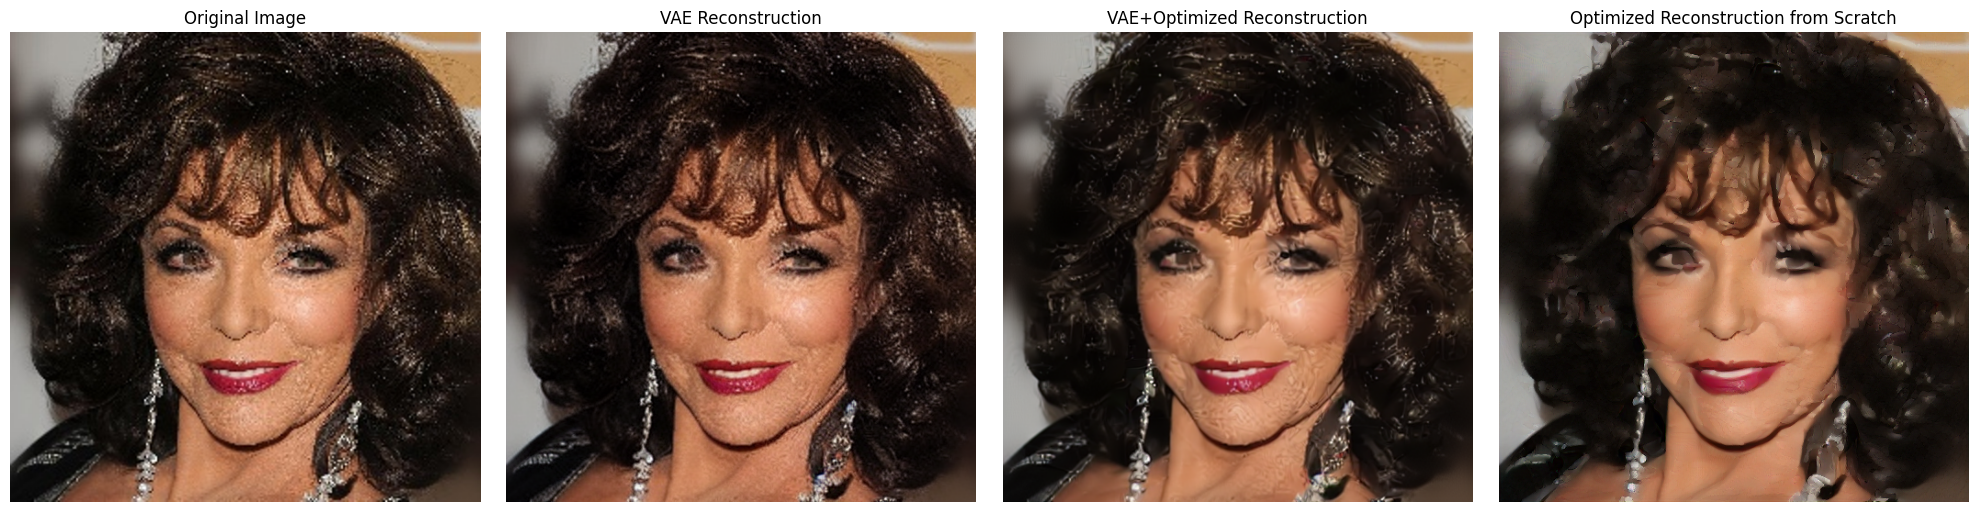

In [ ]:
# Plot the images
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes = axes.flatten()
axes[0].imshow(original_img)
axes[0].set_title("Original Image")
axes[1].imshow(recon1_img)
axes[1].set_title("VAE Reconstruction")
axes[2].imshow(recon2_img)
axes[2].set_title("VAE+Optimized Reconstruction")
axes[3].imshow(recon3_img)
axes[3].set_title("Optimized Reconstruction from Noise")
for ax in axes.flatten():
    ax.axis('off')
plt.tight_layout()
plt.show()